In [1]:
%load_ext autoreload
%autoreload
from IPython.display import clear_output

import os
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import sys
import subprocess
import pdb
import time
import datetime
import math
import random
import _pickle as cPickle
from collections import defaultdict
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib nbagg

from six.moves import zip_longest
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import distributions as tfd
from tensorflow.keras.preprocessing.sequence import pad_sequences

from data_structure import get_batches, get_test_batches
from components import tf_log, sample_latents, compute_kl_loss, dynamic_rnn, dynamic_bi_rnn

from topic_beam_search_decoder import BeamSearchDecoder

In [2]:
PAD = '<pad>' # This has a vocab id, which is used to pad the encoder input, decoder input and target sequence
UNK = '<unk>' # This has a vocab id, which is used to represent out-of-vocabulary words
BOS = '<p>' # This has a vocab id, which is used at the beginning of every decoder input sequence
EOS = '</p>' # This has a vocab id, which is used at the end of untruncated target sequences

# load data & set config

In [3]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)

flags = tf.app.flags

flags.DEFINE_string('gpu', '2', 'visible gpu')

flags.DEFINE_string('mode', 'train', 'set train or eval')

flags.DEFINE_string('data_path', 'data/bags/instances.pkl', 'path of data')
flags.DEFINE_string('modeldir', 'model/topic_vae', 'directory of model')
flags.DEFINE_string('modelname', 'bags', 'name of model')

flags.DEFINE_integer('epochs', 50, 'epochs')
flags.DEFINE_integer('batch_size', 64, 'number of sentences in each batch')
flags.DEFINE_integer('log_period', 1000, 'valid period')

flags.DEFINE_string('opt', 'Adagrad', 'optimizer')
flags.DEFINE_float('lr', 0.1, 'lr')
flags.DEFINE_float('reg', 1., 'regularization term')
flags.DEFINE_float('grad_clip', 5., 'grad_clip')

flags.DEFINE_float('keep_prob', 0.8, 'dropout rate')
flags.DEFINE_float('word_keep_prob', 0.75, 'word dropout rate')

flags.DEFINE_bool('warmup', True, 'flg of warming up')
flags.DEFINE_integer('epochs_cycle', 5, 'number of epochs within a cycle')
flags.DEFINE_float('r_cycle', 0.5, 'proportion used to increase beta within a cycle')
flags.DEFINE_integer('warmup_topic', 0, 'warmup period for KL of topic')

flags.DEFINE_integer('beam_width', 2, 'beam_width')
flags.DEFINE_float('length_penalty_weight', 0.0, 'length_penalty_weight')

flags.DEFINE_integer('n_topic', 20, 'number of topic')
flags.DEFINE_integer('dim_hidden_bow', 256, 'dim of hidden bow')
flags.DEFINE_integer('dim_latent_bow', 32, 'dim of latent topic')
flags.DEFINE_integer('dim_emb', 256, 'dim_emb')
flags.DEFINE_integer('dim_hidden', 512, 'dim_hidden')
flags.DEFINE_integer('dim_hidden_topic', 512, 'dim_hidden_topic')
flags.DEFINE_integer('dim_latent', 32, 'dim_latent')
flags.DEFINE_bool('bidirectional', True, 'flg of bidirectional encoding')

# for evaluation
flags.DEFINE_string('refdir', 'ref', 'refdir')
flags.DEFINE_string('outdir', 'out', 'outdir')

flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_bool('logtostderr', True, 'kernel')
flags.DEFINE_bool('showprefixforinfo', False, '')
flags.DEFINE_bool('verbosity', False, '')
# flags.DEFINE_integer('stderrthreshold', 20, 'kernel')

config = flags.FLAGS

flags.DEFINE_string('modelpath', os.path.join(config.modeldir, config.modelname), 'path of model')

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = config.gpu

In [5]:
instances_train, instances_dev, instances_test, word_to_idx, idx_to_word, bow_idxs = cPickle.load(open(config.data_path,'rb'))

In [6]:
train_batches = get_batches(instances_train, config.batch_size)
dev_batches = get_batches(instances_dev, config.batch_size)
test_batches = get_test_batches(instances_test, config.batch_size)

In [7]:
flags.DEFINE_integer('PAD_IDX', word_to_idx[PAD], 'PAD_IDX')
flags.DEFINE_integer('UNK_IDX', word_to_idx[UNK], 'UNK_IDX')
flags.DEFINE_integer('BOS_IDX', word_to_idx[BOS], 'BOS_IDX')
flags.DEFINE_integer('EOS_IDX', word_to_idx[EOS], 'EOS_IDX')

flags.DEFINE_integer('n_vocab', len(word_to_idx), 'n_vocab')
flags.DEFINE_integer('dim_bow', len(bow_idxs), 'dim_bow')

maximum_iterations = max([max([instance.max_sent_l for instance in batch]) for ct, batch in dev_batches])
flags.DEFINE_integer('maximum_iterations', maximum_iterations, 'maximum_iterations')

flags.DEFINE_integer('cycle_steps', len(train_batches)*config.epochs_cycle, 'number of steps for each cycle')

In [8]:
def debug_shape(variables):
    sample_batch = dev_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)
    for _variable, variable in zip(_variables, variables):
        if hasattr(variable, 'name'):
            print(variable.name, ':', _variable.shape)
        else:
            print(_variable.shape)

def debug_value(variables, return_value=False):
    sample_batch = test_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)

    if return_value: 
        return _variables
    else:
        for _variable, variable in zip(_variables, variables):
            if hasattr(variable, 'name'):
                print(variable.name, ':', _variable)
            else:
                print(_variable)
                
def check_shape(variables):
    if 'sess' in globals(): raise
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    sample_batch = test_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)
    for _variable, variable in zip(_variables, variables):
        if hasattr(variable, 'name'):
            print(variable.name, ':', _variable.shape)
        else:
            print(_variable.shape)
            
    sess.close()
    
def check_value(variables):
    if 'sess' in globals(): raise
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    sample_batch = test_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)
    for _variable, variable in zip(_variables, variables):
        if hasattr(variable, 'name'):
            print(variable.name, ':', _variable)
        else:
            print(_variable.shape)
            
    sess.close()    
    

# run model 

## init

In [9]:
def get_feed_dict(batch, mode='train'):
    bow = np.array([instance.bow for instance in batch]).astype(np.float32)
    keep_prob = config.keep_prob if mode == 'train' else 1.0
    feed_dict = {
                t_variables['bow']: bow, 
                t_variables['keep_prob']: keep_prob
    }
    return  feed_dict

In [10]:
tf.reset_default_graph()

t_variables = {}
t_variables['bow'] = tf.placeholder(tf.float32, [None, config.dim_bow])
t_variables['keep_prob'] = tf.placeholder(tf.float32)

# tree_idxs = {0:[1, 2], 
#              1:[10, 11], 2:[20, 21, 22], 
#              10: [100, 101], 11: [110, 111, 112], 20: [200, 201], 21: [210, 211], 22:[220, 221, 222]
#              }

# tree_idxs = {0:[1, 2, 3], 
#                       1:[10, 11], 2:[20, 21], 3:[30, 31]}

tree_idxs = {0:[1, 2, 3], 
              1:[10, 11, 12], 2:[20, 21, 22], 3:[30, 31, 32]}


# tree_idxs = {0:[1, 2, 3], 
#                       1:[10, 11], 2:[20, 21], 3:[30, 31],
#                       10: [100, 101], 11: [110, 111], 20: [200, 201], 21: [210, 211], 30:[300, 301], 31:[310, 311]}

topic_idxs = [0] + [idx for child_idxs in tree_idxs.values() for idx in child_idxs]

## doubly rnn

In [11]:
class DoublyRNNCell:
    def __init__(self, dim_hidden, output_layer=None):
        self.dim_hidden = dim_hidden
        
        self.ancestral_layer=tf.layers.Dense(units=dim_hidden, activation=tf.nn.tanh, name='ancestral')
        self.fraternal_layer=tf.layers.Dense(units=dim_hidden, activation=tf.nn.tanh, name='fraternal')
        self.hidden_layer = tf.layers.Dense(units=dim_hidden, activation=tf.nn.tanh, name='hidden')
        
        self.output_layer=output_layer
        
    def __call__(self, state_ancestral, state_fraternal, reuse=True):
        with tf.variable_scope('input', reuse=reuse):
            state_ancestral = self.ancestral_layer(state_ancestral)
            state_fraternal = self.fraternal_layer(state_fraternal)

        with tf.variable_scope('output', reuse=reuse):
            state_hidden = self.hidden_layer(state_ancestral + state_fraternal)
            if self.output_layer is not None: 
                output = self.output_layer(state_hidden)
            else:
                output = state_hidden
            
        return output, state_hidden
    
    def get_initial_state(self, name):
        initial_state = tf.get_variable(name, [1, self.dim_hidden], dtype=tf.float32)
        return initial_state
    
    def get_zero_state(self, name):
        zero_state = tf.zeros([1, self.dim_hidden], dtype=tf.float32, name=name)
        return zero_state

In [12]:
def doubly_rnn(dim_hidden, tree_idxs, initial_state_parent=None, initial_state_sibling=None, output_layer=None, name=''):
    outputs, states_parent = {}, {}
    
    with tf.variable_scope(name, reuse=False):
        doubly_rnn_cell = DoublyRNNCell(dim_hidden, output_layer)

        if initial_state_parent is None: 
            initial_state_parent = doubly_rnn_cell.get_initial_state('init_state_parent')
#             initial_state_parent = doubly_rnn_cell.get_zero_state('init_state_parent')
        if initial_state_sibling is None: 
#             initial_state_sibling = doubly_rnn_cell.get_initial_state('init_state_sibling')
            initial_state_sibling = doubly_rnn_cell.get_zero_state('init_state_sibling')
        output, state_sibling = doubly_rnn_cell(initial_state_parent, initial_state_sibling, reuse=False)
        outputs[0], states_parent[0] = output, state_sibling

        for parent_idx, child_idxs in tree_idxs.items():
            state_parent = states_parent[parent_idx]
            state_sibling = initial_state_sibling
            for child_idx in child_idxs:
                output, state_sibling = doubly_rnn_cell(state_parent, state_sibling)
                outputs[child_idx], states_parent[child_idx] = output, state_sibling

    return outputs, states_parent

## stick break

In [13]:
def hierarchical_sbp(tree_sticks_topic, tree_sticks_branch):
    tree_prob_topic = {}
    rest_topics = {}

    # calculate topic probability and save
    stick_topic = tree_sticks_topic[0]
    tree_prob_topic[0] = stick_topic
    rest_topics[0] = 1.-stick_topic
    for parent_idx, child_idxs in tree_idxs.items():
        rest_topic = rest_topics[parent_idx]
        rest_branch = 1.
        for child_idx in child_idxs:
            # calculate topic probability
            if child_idx == child_idxs[-1]: # last child
                prob_branch = rest_branch # phi
            else:
                stick_branch = tree_sticks_branch[child_idx] # psi
                prob_branch = stick_branch * rest_branch # phi

            if not child_idx in tree_idxs: # leaf childs
                prob_topic = prob_branch * rest_topic # pi
            else:
                stick_topic = tree_sticks_topic[child_idx] # upsilon
                prob_topic = stick_topic * prob_branch * rest_topic # pi

            # save topic probability and update rest stick length
            tree_prob_topic[child_idx] = prob_topic
            rest_branch = (1.- stick_branch) * rest_branch
            rest_topics[child_idx] = (1.-stick_topic)*prob_branch * rest_topic
            
    return tree_prob_topic

## build model

In [14]:
def get_tree_topic_bow(tree_topic_embeddings):
    def get_depth(parent_idx=0, tree_depth = None, depth=1):
        if tree_depth is None: tree_depth={0: depth}

        child_idxs = tree_idxs[parent_idx]
        depth +=1
        for child_idx in child_idxs:
            tree_depth[child_idx] = depth
            if child_idx in tree_idxs: get_depth(child_idx, tree_depth, depth)
        return tree_depth
       
    def softmax_with_temperature(logits, axis=None, name=None, temperature=1.):
        if axis is None:
            axis = -1
        return tf.exp(logits / temperature) / tf.reduce_sum(tf.exp(logits / temperature), axis=axis)
    
    tree_depth = get_depth()

    tree_topic_bow = {}
    for topic_idx, depth in tree_depth.items():
        topic_embedding = tree_topic_embeddings[topic_idx]
        temperature = tf.constant(10. ** (1./depth), dtype=tf.float32)
        logits = tf.matmul(topic_embedding, bow_embeddings, transpose_b=True)
        tree_topic_bow[topic_idx] = softmax_with_temperature(logits, axis=-1, temperature=temperature)
    
    return tree_topic_bow

In [15]:
# encode bow
with tf.variable_scope('topic/enc', reuse=False):
    hidden_bow_ = tf.layers.Dense(units=config.dim_hidden_bow, activation=tf.nn.tanh, name='hidden_bow')(t_variables['bow'])
    hidden_bow = tf.layers.Dropout(t_variables['keep_prob'])(hidden_bow_)
    means_bow = tf.layers.Dense(units=config.dim_latent_bow, name='mean_bow')(hidden_bow)
    logvars_bow = tf.layers.Dense(units=config.dim_latent_bow, kernel_initializer=tf.constant_initializer(0), bias_initializer=tf.constant_initializer(0), name='logvar_bow')(hidden_bow)
    latents_bow = sample_latents(means_bow, logvars_bow) # sample latent vectors
    prob_layer = lambda h: tf.nn.sigmoid(tf.matmul(latents_bow, h, transpose_b=True))
    
    tree_sticks_topic, tree_states_sticks_topic = doubly_rnn(config.dim_latent_bow, tree_idxs, output_layer=prob_layer, name='sticks_topic')
    tree_sticks_branch, tree_states_sticks_branch = doubly_rnn(config.dim_latent_bow, tree_idxs, output_layer=prob_layer, name='sticks_branch')

    tree_prob_topic = hierarchical_sbp(tree_sticks_topic, tree_sticks_branch)
    prob_topic = tf.concat([tree_prob_topic[topic_idx] for topic_idx in topic_idxs], 1)

# decode bow
with tf.variable_scope('shared', reuse=False):
    embeddings = tf.get_variable('emb', [config.n_vocab, config.dim_emb], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer()) # embeddings of vocab

bow_embeddings = tf.nn.embedding_lookup(embeddings, bow_idxs) # embeddings of each bow features

with tf.variable_scope('topic/dec', reuse=False):
    emb_layer = tf.layers.Dense(units=config.dim_emb, name='output')
    tree_topic_embeddings, tree_states_topic_embeddings = doubly_rnn(config.dim_emb, tree_idxs, output_layer=emb_layer, name='emb_topic')
#     topic_embeddings = tf.get_variable('topic_emb', [len(topic_idxs), config.dim_emb], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer()) # embeddings of topics
#     tree_topic_embeddings = {topic_idx: tf.expand_dims(topic_embeddings[topic_idxs.index(topic_idx)], 0) for topic_idx in topic_idxs}

    tree_topic_bow = get_tree_topic_bow(tree_topic_embeddings) # bow vectors for each topic
    
    topic_bow = tf.concat([tree_topic_bow[topic_idx] for topic_idx in topic_idxs], 0)
    logits_bow = tf_log(tf.matmul(prob_topic, topic_bow)) # predicted bow distribution

## define loss

In [16]:
def get_tree_mask_reg(tree_idxs):
    tree_mask_reg = np.ones([len(topic_idxs), len(topic_idxs)], dtype=np.float32)
    parent_to_descendant_idxs = {parent_idx: get_descendant_idxs(parent_idx) for parent_idx in tree_idxs}
    
    for parent_idx, descendant_idxs in parent_to_descendant_idxs.items():
        for descendant_idx in descendant_idxs:
            tree_mask_reg[topic_idxs.index(parent_idx), topic_idxs.index(descendant_idx)] = tree_mask_reg[topic_idxs.index(descendant_idx), topic_idxs.index(parent_idx)] = 0.
            
    return tree_mask_reg

def get_depth_mask_reg(tree_idxs):
    depth_mask_reg = np.zeros([len(topic_idxs), len(topic_idxs)], dtype=np.float32)
    
    depth_mask_reg[0, 0] = 1.
    for parent_idx, child_idxs in tree_idxs.items():
        for child_idx1 in child_idxs:
            for child_idx2 in child_idxs:
                depth_mask_reg[topic_idxs.index(child_idx1), topic_idxs.index(child_idx2)] = 1.
                
    return depth_mask_reg

def get_descendant_idxs(parent_idx, descendant_idxs = None):
    if descendant_idxs is None: descendant_idxs = []
    
    child_idxs = tree_idxs[parent_idx]
    descendant_idxs += child_idxs
    for child_idx in child_idxs:
        if child_idx in tree_idxs: get_descendant_idxs(child_idx, descendant_idxs)
    return descendant_idxs

In [17]:
# define losses
topic_losses_recon = -tf.reduce_sum(tf.multiply(t_variables['bow'], logits_bow), 1)
topic_loss_recon = tf.reduce_mean(topic_losses_recon) # negative log likelihood of each words

topic_loss_kl = compute_kl_loss(means_bow, logvars_bow) # KL divergence b/w latent dist & gaussian std

topic_bow_norm = topic_bow / tf.norm(topic_bow, axis=1, keepdims=True)
topic_dots = tf.clip_by_value(tf.matmul(topic_bow_norm, tf.transpose(topic_bow_norm)), -1., 1.)
# topic_loss_reg = tf.reduce_mean(tf.square(topic_dots - tf.eye(len(topic_idxs))))
tree_mask_reg = get_tree_mask_reg(tree_idxs)
# tree_mask_reg = get_depth_mask_reg(tree_idxs)
topic_losses_reg = tf.square(topic_dots - tf.eye(len(topic_idxs))) * tree_mask_reg
topic_loss_reg = tf.reduce_sum(topic_losses_reg) / tf.reduce_sum(tree_mask_reg)

# topic_embeddings = tf.concat([tree_topic_embeddings[topic_idx] for topic_idx in topic_idxs], 0)
# topic_embeddings_norm = topic_embeddings / tf.norm(topic_embeddings, axis=1, keepdims=True)
# topic_dots = tf.clip_by_value(tf.matmul(topic_embeddings_norm, tf.transpose(topic_embeddings_norm)), -1., 1.)
# tree_mask_reg = get_tree_mask_reg(tree_idxs)
# topic_loss_reg = tf.reduce_sum(tf.square(topic_dots - tf.eye(len(topic_idxs))) * tree_mask_reg) / tf.reduce_sum(tree_mask_reg)

# topic_embeddings = tf.concat([tree_topic_embeddings[topic_idx] for topic_idx in topic_idxs], 0)
# topic_embeddings_norm = topic_embeddings / tf.norm(topic_embeddings, axis=1, keepdims=True)
# topic_dots = tf.clip_by_value(tf.matmul(topic_embeddings_norm, tf.transpose(topic_embeddings_norm)), -1., 1.)
# topic_angles = tf.acos(topic_dots)
# tree_mask_reg = get_tree_mask_reg(tree_idxs)

# mean_angles = tf.reduce_sum(topic_angles*tree_mask_reg) / tf.reduce_sum(tree_mask_reg)
# var_angles = tf.reduce_sum(tf.square(topic_angles-mean_angles)*tree_mask_reg) / tf.reduce_sum(tree_mask_reg)
# mean_angles = tf.reduce_mean(topic_angles)
# var_angles = tf.reduce_mean(tf.square(topic_angles-mean_angles))
# mean_angles = tf.asin(tf.sqrt(tf.linalg.det(topic_dots * tree_mask_reg)))
# var_angles = tf.square(tf.constant(np.pi/2., dtype=tf.float32)-mean_angles)

# topic_loss_reg = var_angles - mean_angles

global_step = tf.Variable(0, name='global_step',trainable=False)

loss = topic_loss_recon + topic_loss_kl + config.reg * topic_loss_reg

# define optimizer
if config.opt == 'Adam':
    optimizer = tf.train.AdamOptimizer(config.lr)
elif config.opt == 'Adagrad':
    optimizer = tf.train.AdagradOptimizer(config.lr)

grad_vars = optimizer.compute_gradients(loss)
clipped_grad_vars = [(tf.clip_by_value(grad, -config.grad_clip, config.grad_clip), var) for grad, var in grad_vars]
opt = optimizer.apply_gradients(clipped_grad_vars, global_step=global_step)

# monitor
n_bow = tf.reduce_sum(t_variables['bow'], 1)
topic_ppls = tf.divide(topic_losses_recon, tf.maximum(1e-5, n_bow))
topics_freq_bow_indices = tf.nn.top_k(topic_bow, 10, name='topic_freq_bow').indices

In [18]:
def get_loss(sess, batches):
    losses = []
    ppl_list = []
    for ct, batch in batches:
        feed_dict = get_feed_dict(batch, mode='test')
        loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch, ppls_batch \
            = sess.run([loss, topic_loss_recon, topic_loss_kl, topic_loss_reg, topic_ppls], feed_dict = feed_dict)
        losses += [[loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch]]
        ppl_list += list(ppls_batch)
    loss_mean, topic_loss_recon_mean, topic_loss_kl_mean, topic_loss_reg_mean = np.mean(losses, 0)
    ppl_mean = np.exp(np.mean(ppl_list))
    return loss_mean, topic_loss_recon_mean, topic_loss_kl_mean, topic_loss_reg_mean, ppl_mean

In [19]:
def print_topic_sample(parent_idx=0, topics_freq_bow_idxs=None, depth = 0):
    if topics_freq_bow_idxs is None:
        topics_freq_bow_idxs = bow_idxs[sess.run(topics_freq_bow_indices)]
        topic_freq_bow_idxs = topics_freq_bow_idxs[topic_idxs.index(parent_idx)]
        print(parent_idx, ' '.join([idx_to_word[idx] for idx in topic_freq_bow_idxs]))
    
    child_idxs = tree_idxs[parent_idx]
    depth += 1
    for child_idx in child_idxs:
        topic_freq_bow_idxs = topics_freq_bow_idxs[topic_idxs.index(child_idx)]
        print('  '*depth, child_idx, ' '.join([idx_to_word[idx] for idx in topic_freq_bow_idxs]))
        
        if child_idx in tree_idxs: print_topic_sample(child_idx, topics_freq_bow_idxs, depth)

In [20]:
if 'sess' in globals(): sess.close()
sess = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1))
sess.run(tf.global_variables_initializer())

losses_train = []
ppls_train = []
loss_min = np.inf
beta_eval = 1.
epoch = 0
train_batches = get_batches(instances_train, config.batch_size, iterator=True)
saver = tf.train.Saver(max_to_keep=10)

log_df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(
                    list(zip(*[['','','','TRAIN:','TM','','','','VALID:','TM','','',''],
                            ['Time','Ep','Ct','LOSS','PPL','NLL','KL','REG','LOSS','PPL','NLL','KL','REG']]))))

In [21]:
if len(log_df) == 0:
    cmd_rm = 'rm -r %s' % config.modeldir
    res = subprocess.call(cmd_rm.split())

    cmd_mk = 'mkdir %s' % config.modeldir
    res = subprocess.call(cmd_mk.split())

time_start = time.time()
while epoch < config.epochs:
    for ct, batch in train_batches:
        feed_dict = get_feed_dict(batch)

        _, loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch, ppls_batch, global_step_log = \
        sess.run([opt, loss, topic_loss_recon, topic_loss_kl, topic_loss_reg, topic_ppls, tf.train.get_global_step()], feed_dict = feed_dict)
            
        losses_train += [[loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch]]
        ppls_train += list(ppls_batch)

        if global_step_log%config.log_period==0:
            loss_train, topic_loss_recon_train, topic_loss_kl_train, topic_loss_reg_train = np.mean(losses_train, 0)
            ppl_train = np.exp(np.mean(ppls_train))
            loss_dev, topic_loss_recon_dev, topic_loss_kl_dev, topic_loss_reg_dev, ppl_dev = get_loss(sess, dev_batches)
            
#             if loss_dev < loss_min:
#                 loss_min = loss_dev
#                 saver.save(sess, config.modelpath, global_step=global_step_log)

            clear_output()
    
            time_log = int(time.time() - time_start)
            log_series = pd.Series([time_log, epoch, ct, \
                    '%.2f'%loss_train, '%.0f'%ppl_train, '%.2f'%topic_loss_recon_train, '%.2f'%topic_loss_kl_train, '%.2f'%topic_loss_reg_train, \
                    '%.2f'%loss_dev, '%.0f'%ppl_dev, '%.2f'%topic_loss_recon_dev, '%.2f'%topic_loss_kl_dev, '%.2f'%topic_loss_reg_dev],
                    index=log_df.columns)
            log_df.loc[global_step_log] = log_series
            display(log_df)
            
            # visualize topic
            print_topic_sample()

            time_start = time.time()
            
    epoch += 1
    train_batches = get_batches(instances_train, config.batch_size, iterator=True)
    
display(log_df)
print_topic_sample()    

TRAIN:   TM                        VALID:   TM          \
       Time  Ep    Ct    LOSS  PPL     NLL      KL   REG    LOSS  PPL     NLL   
1000     13   0   999  218.47  676  115.95  102.23  0.30  107.60  567  106.20   
2000     11   0  1999  167.13  634  115.07   51.80  0.25  107.05  554  105.85   
3000     12   1   724  149.78  618  114.74   34.81  0.23  106.93  560  106.13   
4000     12   1  1724  140.86  610  114.37   26.27  0.22  106.49  554  105.84   
5000     12   2   449  135.61  604  114.24   21.16  0.21  106.43  552  105.62   
6000     12   2  1449  131.97  596  113.99   17.77  0.21  106.04  535  105.18   
7000     13   3   174  129.36  589  113.78   15.37  0.21  106.38  544  105.48   
8000     12   3  1174  127.39  582  113.61   13.57  0.21  106.07  533  105.07   
9000     11   3  2174  125.78  577  113.39   12.18  0.21  106.07  527  104.95   
10000    11   4   899  124.51  572  113.24   11.07  0.20  105.82  514  104.49   
11000    11   4  1899  123.47  567  113.10   10.17  0.20  105.52  508  104.35   
12000    11   5   624  122.61  563  112.99    9.42  0.20  105.61  521  104.56   
13000    11   5  1624  121.86  559  112.87    8.78  0.20  105.58  507  104.35   
14000    11   6   349  121.19  556  112.75    8.24  0.20  105.45  509  104.25   
15000    11   6  1349  120.60  553  112.63    7.78  0.20  105.43  507  104.26   
16000    11   7    74  120.10  550  112.54    7.37  0.20  104.96  498  103.83   
17000    11   7  1074  119.67  547  112.47    7.01  0.19  105.15  495  103.90   
18000    11   7  2074  119.27  545  112.39    6.69  0.19  105.31  503  104.03   
19000    11   8   799  118.90  543  112.31    6.40  0.19  105.23  493  103.86   
20000    11   8  1799  118.59  541  112.25    6.15  0.19  105.25  495  103.92   
21000    11   9   524  118.27  539  112.17    5.91  0.19  105.38  499  104.07   
22000    11   9  1524  118.01  537  112.12    5.70  0.19  105.14  495  103.83   
23000    11  10   249  117.77  535  112.08    5.51  0.18  104.85  482  103.57   
24000    11  10  1249  117.54  534  112.03    5.33  0.18  104.94  491  103.62   
25000    11  10  2249  117.34  533  111.98    5.17  0.18  105.00  491  103.71   
26000    11  11   974  117.12  531  111.92    5.02  0.18  105.18  492  103.80   
27000    11  11  1974  116.96  530  111.90    4.88  0.18  104.83  485  103.65   
28000    11  12   699  116.79  529  111.86    4.75  0.18  105.17  495  103.80   
29000    11  12  1699  116.63  528  111.82    4.63  0.18  105.37  502  104.13   
30000    11  13   424  116.49  527  111.80    4.52  0.18  105.06  494  103.81   
...     ...  ..   ...     ...  ...     ...     ...   ...     ...  ...     ...   
84000    11  36  2099  113.33  497  110.77    2.45  0.10  104.11  457  102.61   
85000    11  37   824  113.29  497  110.75    2.45  0.10  103.89  451  102.35   
86000    11  37  1824  113.27  496  110.74    2.44  0.10  103.87  448  102.34   
87000    11  38   549  113.24  496  110.72    2.43  0.10  103.95  449  102.32   
88000    11  38  1549  113.22  495  110.70    2.42  0.10  104.08  454  102.47   
89000    11  39   274  113.19  495  110.68    2.41  0.10  103.83  445  102.17   
90000    11  39  1274  113.16  494  110.66    2.41  0.10  103.59  438  101.92   
91000    11  39  2274  113.13  494  110.64    2.40  0.10  103.78  442  102.09   
92000    11  40   999  113.11  493  110.62    2.39  0.09  103.83  444  102.12   
93000    11  40  1999  113.08  492  110.59    2.39  0.09  104.01  450  102.27   
94000    11  41   724  113.05  492  110.57    2.38  0.09  103.62  437  101.77   
95000    11  41  1724  113.02  491  110.55    2.38  0.09  103.80  439  101.96   
96000    11  42   449  112.99  491  110.53    2.38  0.09  103.62  434  101.78   
97000    11  42  1449  112.97  490  110.50    2.37  0.09  103.56  435  101.77   
98000    11  43   174  112.94  490  110.48    2.37  0.09  103.54  432  101.66   
99000    11  43  1174  112.92  489  110.46    2.36  0.09  103.62  432  101.74   
100000   11  43  2174  112.89  488  110.44    2.36  0.

0 carry pockets strap room back nice work shoulder quality small
   1 ... months $ bought quality time cheap 'm return buy
     10 price perfectly recommend mac protect pro bought protects nice book
     11 ! color love ordered cover recommend fast picture perfectly happy
     12 cover keyboard bottom hard nice screen pro top air apple
   2 sleeve protection inside air pro snug inch protect nice padding
     20 big fine closed ca stars close material flap issue 'll
     21 ; & pro protection perfectly air retina tablet sleeve laptops
     22 bulky padding slim secure tablet sleek safe simple stylish bill
   3 ipad zipper inch size zip handles hp amazon made reviews
     30 mouse power pocket netbook charger cord room small usb perfectly
     31 ! love ... perfect absolutely awesome highly recommend loves perfectly
     32 perfect love highly recommend easy sturdy stylish ! perfectly light


TRAIN:   TM                        VALID:   TM          \
       Time  Ep    Ct    LOSS  PPL     NLL      KL   REG    LOSS  PPL     NLL   
1000     13   0   999  218.47  676  115.95  102.23  0.30  107.60  567  106.20   
2000     11   0  1999  167.13  634  115.07   51.80  0.25  107.05  554  105.85   
3000     12   1   724  149.78  618  114.74   34.81  0.23  106.93  560  106.13   
4000     12   1  1724  140.86  610  114.37   26.27  0.22  106.49  554  105.84   
5000     12   2   449  135.61  604  114.24   21.16  0.21  106.43  552  105.62   
6000     12   2  1449  131.97  596  113.99   17.77  0.21  106.04  535  105.18   
7000     13   3   174  129.36  589  113.78   15.37  0.21  106.38  544  105.48   
8000     12   3  1174  127.39  582  113.61   13.57  0.21  106.07  533  105.07   
9000     11   3  2174  125.78  577  113.39   12.18  0.21  106.07  527  104.95   
10000    11   4   899  124.51  572  113.24   11.07  0.20  105.82  514  104.49   
11000    11   4  1899  123.47  567  113.10   10.17  0.20  105.52  508  104.35   
12000    11   5   624  122.61  563  112.99    9.42  0.20  105.61  521  104.56   
13000    11   5  1624  121.86  559  112.87    8.78  0.20  105.58  507  104.35   
14000    11   6   349  121.19  556  112.75    8.24  0.20  105.45  509  104.25   
15000    11   6  1349  120.60  553  112.63    7.78  0.20  105.43  507  104.26   
16000    11   7    74  120.10  550  112.54    7.37  0.20  104.96  498  103.83   
17000    11   7  1074  119.67  547  112.47    7.01  0.19  105.15  495  103.90   
18000    11   7  2074  119.27  545  112.39    6.69  0.19  105.31  503  104.03   
19000    11   8   799  118.90  543  112.31    6.40  0.19  105.23  493  103.86   
20000    11   8  1799  118.59  541  112.25    6.15  0.19  105.25  495  103.92   
21000    11   9   524  118.27  539  112.17    5.91  0.19  105.38  499  104.07   
22000    11   9  1524  118.01  537  112.12    5.70  0.19  105.14  495  103.83   
23000    11  10   249  117.77  535  112.08    5.51  0.18  104.85  482  103.57   
24000    11  10  1249  117.54  534  112.03    5.33  0.18  104.94  491  103.62   
25000    11  10  2249  117.34  533  111.98    5.17  0.18  105.00  491  103.71   
26000    11  11   974  117.12  531  111.92    5.02  0.18  105.18  492  103.80   
27000    11  11  1974  116.96  530  111.90    4.88  0.18  104.83  485  103.65   
28000    11  12   699  116.79  529  111.86    4.75  0.18  105.17  495  103.80   
29000    11  12  1699  116.63  528  111.82    4.63  0.18  105.37  502  104.13   
30000    11  13   424  116.49  527  111.80    4.52  0.18  105.06  494  103.81   
...     ...  ..   ...     ...  ...     ...     ...   ...     ...  ...     ...   
84000    11  36  2099  113.33  497  110.77    2.45  0.10  104.11  457  102.61   
85000    11  37   824  113.29  497  110.75    2.45  0.10  103.89  451  102.35   
86000    11  37  1824  113.27  496  110.74    2.44  0.10  103.87  448  102.34   
87000    11  38   549  113.24  496  110.72    2.43  0.10  103.95  449  102.32   
88000    11  38  1549  113.22  495  110.70    2.42  0.10  104.08  454  102.47   
89000    11  39   274  113.19  495  110.68    2.41  0.10  103.83  445  102.17   
90000    11  39  1274  113.16  494  110.66    2.41  0.10  103.59  438  101.92   
91000    11  39  2274  113.13  494  110.64    2.40  0.10  103.78  442  102.09   
92000    11  40   999  113.11  493  110.62    2.39  0.09  103.83  444  102.12   
93000    11  40  1999  113.08  492  110.59    2.39  0.09  104.01  450  102.27   
94000    11  41   724  113.05  492  110.57    2.38  0.09  103.62  437  101.77   
95000    11  41  1724  113.02  491  110.55    2.38  0.09  103.80  439  101.96   
96000    11  42   449  112.99  491  110.53    2.38  0.09  103.62  434  101.78   
97000    11  42  1449  112.97  490  110.50    2.37  0.09  103.56  435  101.77   
98000    11  43   174  112.94  490  110.48    2.37  0.09  103.54  432  101.66   
99000    11  43  1174  112.92  489  110.46    2.36  0.09  103.62  432  101.74   
100000   11  43  2174  112.89  488  110.44    2.36  0.

0 carry pockets strap room back nice work quality shoulder handle
   1 months bought time return cheap back ... $ 'm quality
     10 price perfectly pro recommend mac nice protect book bought hard
     11 color ! love picture blue ordered pink recommend perfectly cover
     12 cover keyboard bottom hard pro apple nice easy screen top
   2 sleeve protection air inside pro smell protect neoprene snug nice
     20 big fine ca flap stars close decent metal material wo
     21 ; & pro tablet air size retina fine protection sleeve
     22 bulky padding secure simple tablet lightweight snug safe slim protective
   3 zipper ipad inch handles size reviews made amazon bought side
     30 pocket power mouse netbook cord charger room drive perfectly small
     31 ! love awesome ... absolutely perfect loves highly wonderful recommend
     32 love perfect highly easy recommend sturdy perfectly ! light awesome


# confirm variables

In [22]:
states_topic_embeddings = tf.concat([tree_states_topic_embeddings[topic_idx] for topic_idx in topic_idxs], 0)

In [23]:
debug_value([states_topic_embeddings[:, :6]])

strided_slice:0 : [[ 1.         -0.9999999  -0.9999964  -1.         -0.9999993   1.        ]
 [-0.99785256 -1.          1.         -0.99406534 -1.          0.99978966]
 [ 1.         -1.          1.         -0.9999997  -1.          1.        ]
 [-1.         -1.          1.          0.9999952  -1.         -0.9999947 ]
 [-1.          0.9972359   1.          1.          0.8365084  -1.        ]
 [-0.99999875  0.9996534   0.999168    1.          0.9934294  -1.        ]
 [-0.99999994  0.99999714  0.9974102   1.          0.9998807  -1.        ]
 [-0.9999998  -1.          1.          0.9531438  -1.         -0.853588  ]
 [ 0.99780965 -1.          1.         -0.9920692  -0.99999934  0.9999967 ]
 [-1.         -1.          1.          1.         -1.         -1.        ]
 [-1.          0.9999979   0.98616433  1.          0.999963   -1.        ]
 [-0.99999917  0.9999999  -0.9980536   1.          0.9999993  -1.        ]
 [-0.99999994  1.         -0.99992406  1.          1.         -1.        ]]


In [24]:
topic_embeddings = tf.concat([tree_topic_embeddings[topic_idx] for topic_idx in topic_idxs], 0)

In [25]:
debug_value([topic_embeddings[:, :6]])

strided_slice_1:0 : [[-0.31987217  0.43885067  0.15174732  0.53789335  0.3522768   0.16720034]
 [-0.32361162 -0.14552425  0.20790239 -0.14348008  0.0482818  -0.23003903]
 [-0.29795346  0.58999276  0.36884582  0.43775266  0.30175313 -0.10782228]
 [ 0.11617041 -0.40046164 -0.79165983  0.6158802   0.7849816  -0.40069017]
 [-0.29394016 -0.5123749   0.6276386   0.32597405  0.20357901  0.8971939 ]
 [-0.10794904 -0.44555923 -0.6699996  -0.64375496 -0.31933916 -0.30186367]
 [ 0.34195223 -0.2043629   0.53775823  0.07154754  0.1545018   0.34499645]
 [ 0.6611324   0.9721337   0.6556879  -0.20538364 -0.8229164  -0.32394084]
 [ 0.00756515  0.37881765 -0.778123   -0.5483138   0.2529977  -0.4087737 ]
 [-0.41716397  1.4987141  -0.37519026  0.02606369 -0.1011503  -0.46944305]
 [ 0.26497224 -0.28483132  0.1409401  -0.44763178 -0.19476557 -0.0045444 ]
 [ 0.19492559 -0.12332937 -0.5587755  -1.6925817  -3.0775206  -1.0572978 ]
 [-0.05481025 -0.14181408  0.36054334  0.19380568 -1.1036402   1.011527  ]]


In [26]:
_topics_bow, = debug_value([topic_bow], return_value=True)
np.max(_topics_bow)

0.82431954

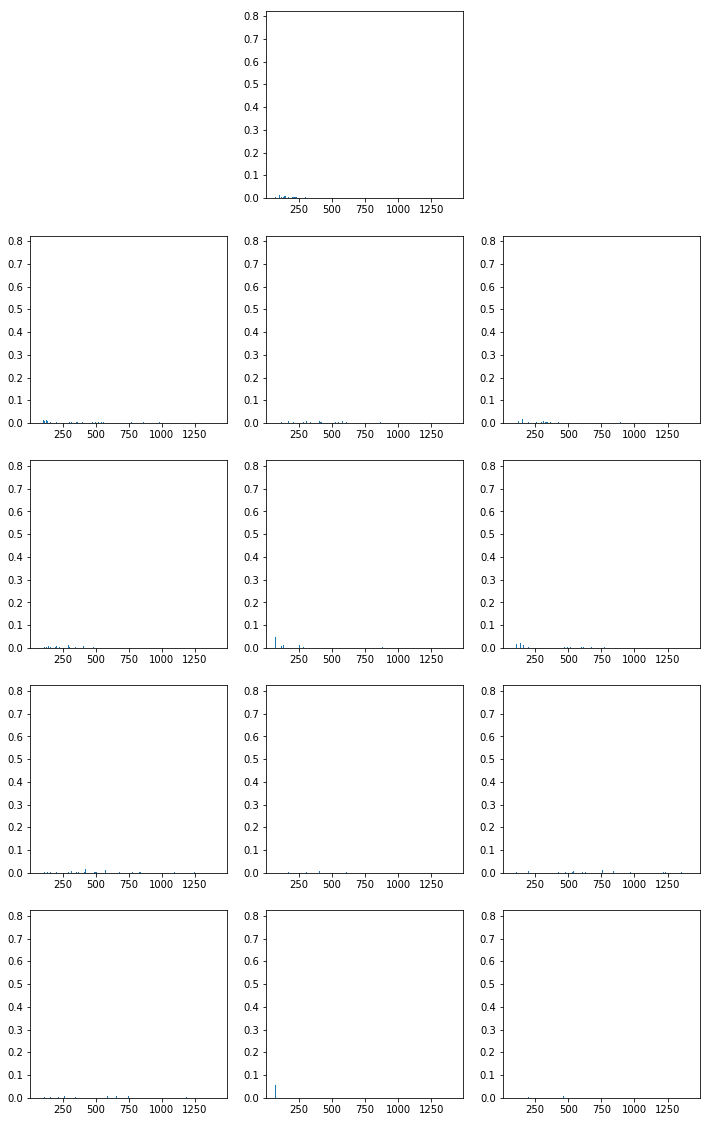

In [27]:
_topics_bow, = debug_value([topic_bow], return_value=True)

plt.figure(figsize=(12, 20))
    
_topic_bow = _topics_bow[0]
plt.subplot(5,3,2)
plt.ylim([0, np.max(_topics_bow)])
plt.bar(bow_idxs, _topic_bow)

for i in range(1, len(topic_idxs)):
    _topic_bow = _topics_bow[i]
    plt.subplot(5,3,i+3)
    plt.ylim([0, np.max(_topics_bow)])
#     plt.axis('off')
    plt.bar(bow_idxs, _topic_bow)

plt.show()

In [28]:
_prob_topics = []
for ct, batch in dev_batches:
    feed_dict = get_feed_dict(batch)
    _prob_topic, = sess.run([prob_topic], feed_dict = feed_dict)
    _prob_topics.append(_prob_topic)
    
_prob_topics = np.concatenate(_prob_topics, 0)
_prob_topic_mean = np.mean(_prob_topics, 0)

print(_prob_topic_mean)

[0.38875443 0.13634856 0.1063983  0.0387852  0.0567136  0.06471842
 0.08044014 0.01212198 0.01859504 0.0066888  0.06062756 0.01967168
 0.01013657]


In [29]:
debug_value([topic_dots])

clip_by_value:0 : [[1.         0.39022726 0.23608154 0.2680145  0.29264572 0.20974651
  0.21086401 0.18748155 0.04813062 0.15952444 0.3494147  0.1316632
  0.19492704]
 [0.39022726 1.         0.18321583 0.30674145 0.26615623 0.16198671
  0.25986376 0.18303636 0.03106311 0.04123127 0.0819167  0.03830842
  0.02350307]
 [0.23608154 0.18321583 0.9999999  0.20788287 0.25698492 0.07440916
  0.22112417 0.17134593 0.07511409 0.20449646 0.19015583 0.02253503
  0.02873662]
 [0.2680145  0.30674145 0.20788287 1.         0.1417325  0.06726129
  0.07822838 0.12521863 0.02506689 0.07968003 0.18533778 0.01291688
  0.01826137]
 [0.29264572 0.26615623 0.25698492 0.1417325  0.9999998  0.290688
  0.34053373 0.05490115 0.03523074 0.10629536 0.18594372 0.01504648
  0.11782688]
 [0.20974651 0.16198671 0.07440916 0.06726129 0.290688   1.
  0.28202853 0.02822478 0.01320903 0.02528232 0.08308369 0.56477743
  0.34375143]
 [0.21086401 0.25986376 0.22112417 0.07822838 0.34053373 0.28202853
  0.9999997  0.08822059 0

In [30]:
debug_value([topic_losses_reg])

mul_2:0 : [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.35680395e-02 9.40903127e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.35023068e-02
  9.64916777e-04 1.70001737e-03 6.71034539e-03 1.46753469e-03
  5.52394253e-04]
 [0.00000000e+00 3.35680395e-02 1.42108547e-14 4.32152860e-02
  6.60412461e-02 5.53672248e-03 4.88958992e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.61592397e-02 5.07827674e-04
  8.25793191e-04]
 [0.00000000e+00 9.40903127e-02 4.32152860e-02 0.00000000e+00
  2.00881008e-02 4.52408148e-03 6.11967873e-03 1.56797059e-02
  6.28348789e-04 6.34890748e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.60412461e-02 2.00881008e-02
  3.19744231e-14 8.44995156e-02 1.15963221e-01 3.01413587e-03
  1.24120479e-03 1.12987040e-02 3.45750675e-02 2.2

In [31]:
tree_mask_reg

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],
      dtype=float32)

In [32]:
_topic_bow, = debug_value([topic_bow], return_value=True)

<BarContainer object of 1035 artists>

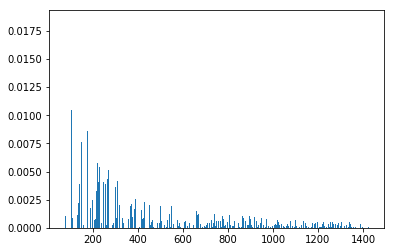

In [33]:
plt.bar(bow_idxs, _topic_bow[0])

<BarContainer object of 1035 artists>

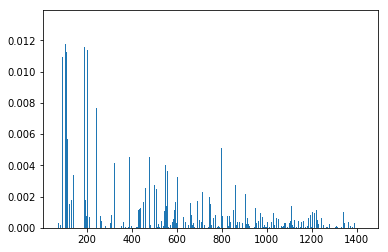

In [34]:
plt.bar(bow_idxs, _topic_bow[1])

<BarContainer object of 1035 artists>

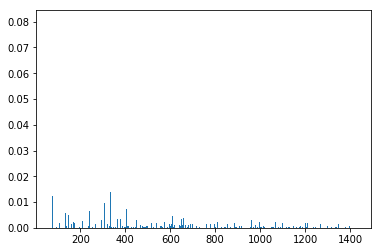

In [35]:
plt.bar(bow_idxs, _topic_bow[2])

<BarContainer object of 1035 artists>

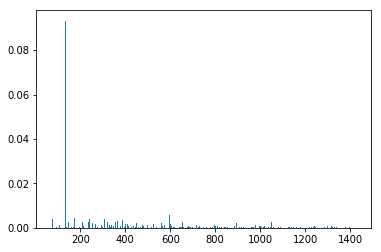

In [36]:
plt.bar(bow_idxs, _topic_bow[3])

In [37]:
np.max(_topic_bow, 1)

array([0.0183948 , 0.01326304, 0.08039191, 0.09322369, 0.07023557,
       0.10503099, 0.07764398, 0.12256365, 0.31641126, 0.09500248,
       0.04939827, 0.82431954, 0.3392444 ], dtype=float32)

<BarContainer object of 1035 artists>

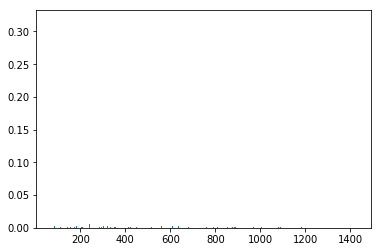

In [38]:
plt.bar(bow_idxs, _topic_bow[-5])

<BarContainer object of 1035 artists>

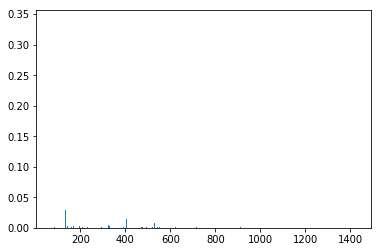

In [39]:
plt.bar(bow_idxs, _topic_bow[-1])

In [40]:
len(bow_idxs)

1035

In [41]:
debug_value([prob_topic[3]])

strided_slice_2:0 : [9.4128662e-01 2.8923694e-02 1.7115781e-03 6.7932922e-03 5.8449781e-03
 1.2503635e-03 8.3860673e-04 5.4780385e-03 2.1607908e-03 3.9254799e-03
 8.7862869e-04 2.1493927e-04 6.9298572e-04]


In [42]:
debug_value([tf.exp(-tf.divide(topic_losses_recon, n_bow))])

Exp_1:0 : [0.00162131 0.00263669 0.00258897 0.00203425 0.00115555 0.00225667
 0.00205019 0.00142096 0.00197553 0.00273317 0.00191035 0.00267991
 0.0044161  0.00267697 0.00300495 0.00156099 0.0016136  0.00344155
 0.00492447 0.00317524 0.00150312 0.00177213 0.00257543 0.00242213
 0.0011503  0.00451574 0.00277955 0.00202453 0.00300749 0.00169602
 0.00239667 0.00252762 0.00365412 0.00205634 0.0047517  0.00135977
 0.00333298 0.00181008 0.00203337 0.00256365 0.0038288  0.00200237
 0.00234737 0.00181445 0.00190797 0.00325656 0.00123817 0.00263717
 0.00250939 0.00195974 0.00224462 0.00125398 0.00438502]


### test

In [43]:
debug_shape([bow, hidden_bow, latents_bow, prob_topic, bow_embeddings, topic_embeddings, topic_bow, prob_bow])

NameError: name 'bow' is not defined

In [ ]:
debug_shape([topic_losses_recon, topic_loss_recon, n_bow, ppls, topic_embeddings_norm, tf.expand_dims(topic_angles_mean, -1), topic_angles_vars])

In [ ]:
debug_value([tf.reduce_sum(tf.square(topic_embeddings_norm), 1)], return_value=True)[0]

In [ ]:
debug_value([tf.reduce_sum(prob_topic, -1), tf.reduce_sum(topic_bow, -1), tf.reduce_sum(tf.exp(prob_bow), 1)])

In [ ]:
sigma_bow = tf.exp(0.5 * logvars_bow)
dist_bow = tfd.Normal(means_bow, sigma_bow)
dist_std = tfd.Normal(0., 1.)
topic_loss_kl_tmp = tf.reduce_mean(tf.reduce_sum(tfd.kl_divergence(dist_bow, dist_std), 1))

In [ ]:
debug_value([topic_loss_recon, topic_loss_kl, topic_loss_kl_tmp])

In [ ]:
_logvars, _means, _kl_losses, _latents, _output_logits = sess.run([logvars, means, kl_losses, latents, output_logits], feed_dict=feed_dict)


In [ ]:
_logvars.shape, _means.shape, _kl_losses.shape, _latents.shape

In [ ]:
_output_logits

In [ ]:
_output_logits, _dec_target_idxs_do, _dec_mask_tokens_do, _recon_loss, _kl_losses, _ = sess.run([output_logits, dec_target_idxs_do, dec_mask_tokens_do, recon_loss, kl_losses, opt], feed_dict=feed_dict)


In [ ]:
tf.reduce_max(output_logits, 2).eval(session=sess, feed_dict=feed_dict).shape

In [ ]:
_output_logits.shape, _dec_target_idxs_do.shape, _dec_mask_tokens_do.shape

In [ ]:
_logits = np.exp(_output_logits) / np.sum(np.exp(_output_logits), 2)[:, :, None]

In [ ]:
_idxs = _dec_target_idxs_do

In [ ]:
_losses = np.array([[-np.log(_logits[i, j, _idxs[i, j]]) for j in range(_idxs.shape[1])] for i in range(_idxs.shape[0])]) * _dec_mask_tokens_do

In [ ]:
np.sum(_losses)/np.sum(_dec_mask_tokens_do)

In [ ]:
_recon_loss

In [ ]:
_kl_losses.shape